# Run training on preprocessed data

Here we optimise the veto condition and maximise cosmic purity over pileup... 

Run: "a" 

Preprocessing is done by `run/run_ml_prep.py` and `src/core/ml_process.py`

## Training datasets

### Signal

* `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`
* `nts.mu2e.CeEndpointMix2BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root`

### Background

* `nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`
* `nts.mu2e.CosmicCRYSignalAllMix2BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root`

In this case I just look at the CRY datasets. 



In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../../src/core", "../../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [2]:
!ls ../../../output/ml/veto/data/a/
!ls -ltrh ../../../output/ml/veto/data/a/CRY_onspill-LH_aw
# !ls ../../output/ml/cosmic/data/sig/b/results.pkl
# ! ls ../output/ml/data/b/bkg/

CRY_mix2BB_onspill-LH_aw       CRY_onspill-LH_aw
CRY_mix2BB_onspill-LH_aw_test  CRY_onspill-LH_aw_test
total 19M
-rw-r--r--. 1 sgrant 65534  12M Nov  6 22:52 results.pkl
-rw-r--r--. 1 sgrant 65534  906 Nov  6 22:52 cut_flow.csv
-rw-r--r--. 1 sgrant 65534 224K Nov  6 22:52 hists.h5
-rw-r--r--. 1 sgrant 65534 7.2M Nov  6 22:52 events.parquet


In [22]:
run = "a"
base_in_path = Path(f"../../../output/ml/veto/data/{run}")
cry_in_path = base_in_path / "CRY_onspill-LH_aw"
cry_mix_in_path = base_in_path/ "CRY_mix2BB_onspill-LH_aw"

cry_data = Load(in_path=cry_in_path).load_pkl()
cry_mix_data = Load(in_path=cry_mix_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../../output/ml/veto/data/a/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/data/a/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../../output/ml/veto/data/a/CRY_mix2BB_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/data/a/CRY_mix2BB_onspill-LH_aw/results.pkl


## Verify data

In [4]:
display(cry_data["cut_flow"])
display(cry_mix_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,2558229,97.981,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,2478081,94.912,96.867,Electron track fits
4,one_reco_electron,Preselect,2050975,78.553,82.765,One reco electron / event
5,is_downstream,Preselect,1127230,43.173,54.961,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,Preselect,320790,12.286,28.458,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,253943,9.726,79.162,Track fit quality > 0.2
8,within_t0,Tracker,203324,7.787,80.067,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,188703,7.227,92.809,Track fit t0 uncertainty (t0err < 0.9 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2160537,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2126506,98.425,98.425,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,2126502,98.425,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,2054714,95.102,96.624,Electron track fits
4,one_reco_electron,Preselect,1479491,68.478,72.005,One reco electron / event
5,is_downstream,Preselect,825750,38.220,55.813,Downstream tracks (p_z > 0 at tracker entrance)
6,is_truth_electron,Preselect,258259,11.953,31.276,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,182914,8.466,70.826,Track fit quality > 0.2
8,within_t0,Tracker,149420,6.916,81.689,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,140902,6.522,94.299,Track fit t0 uncertainty (t0err < 0.9 ns)


[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
CRY


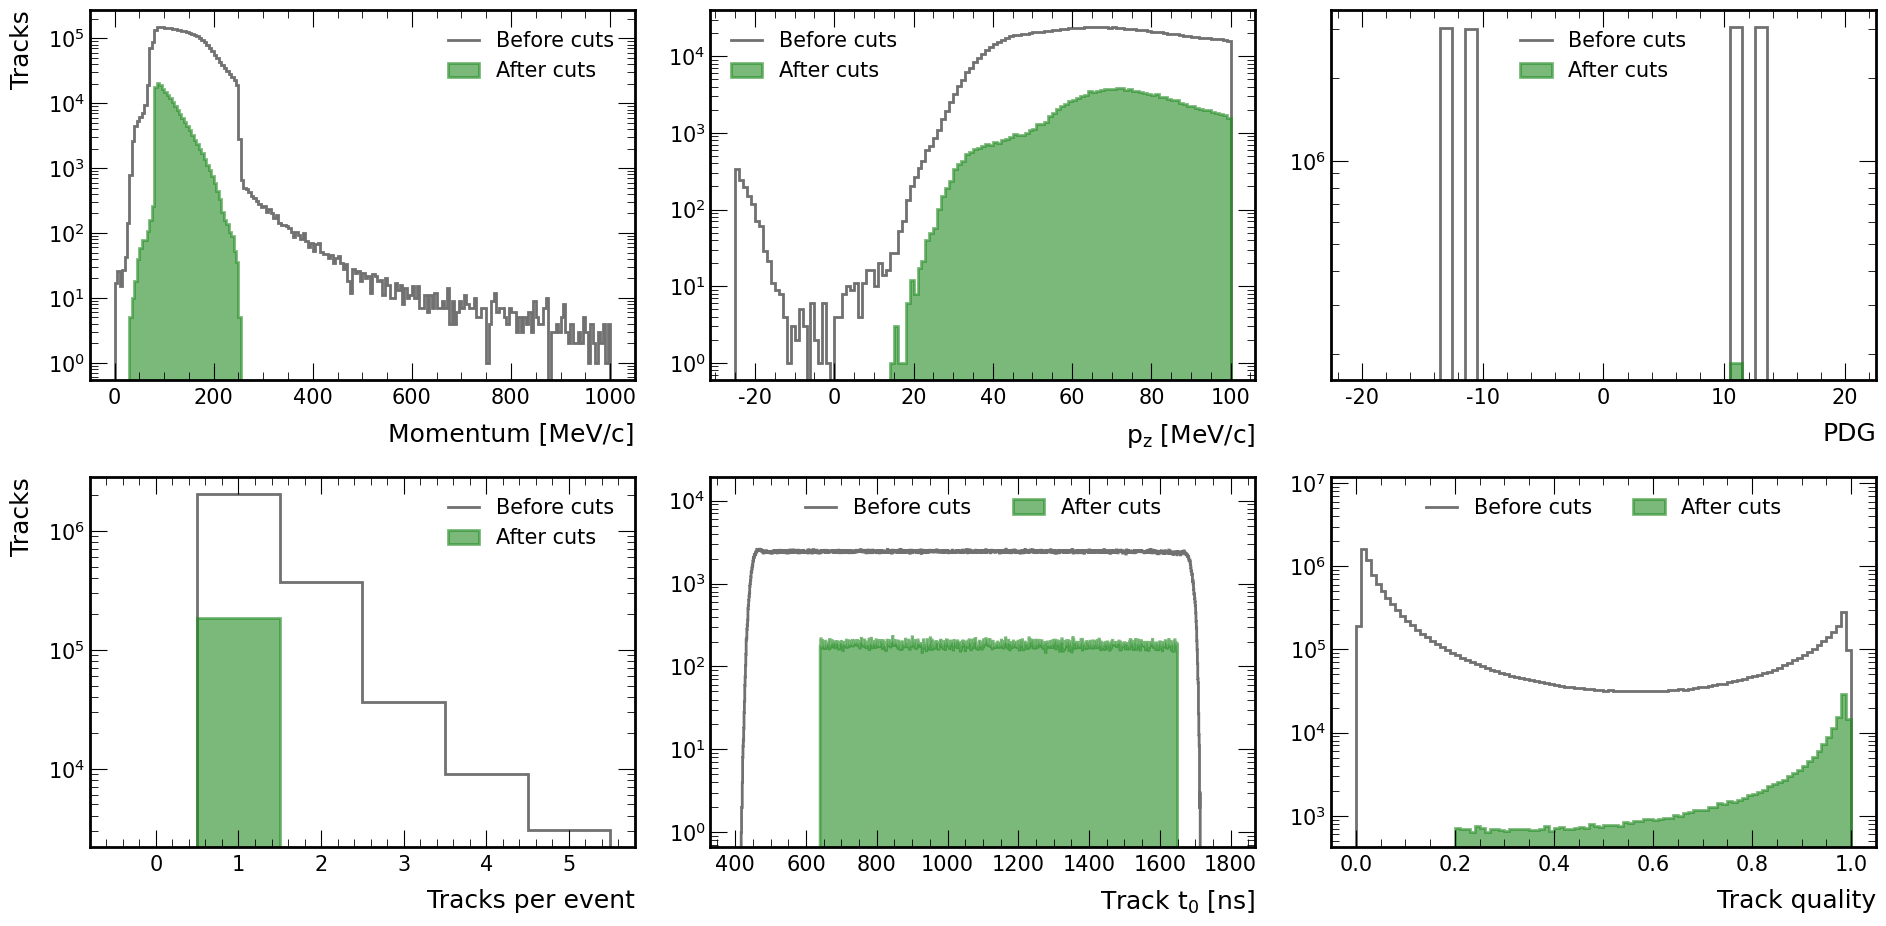

CRY + PILEUP


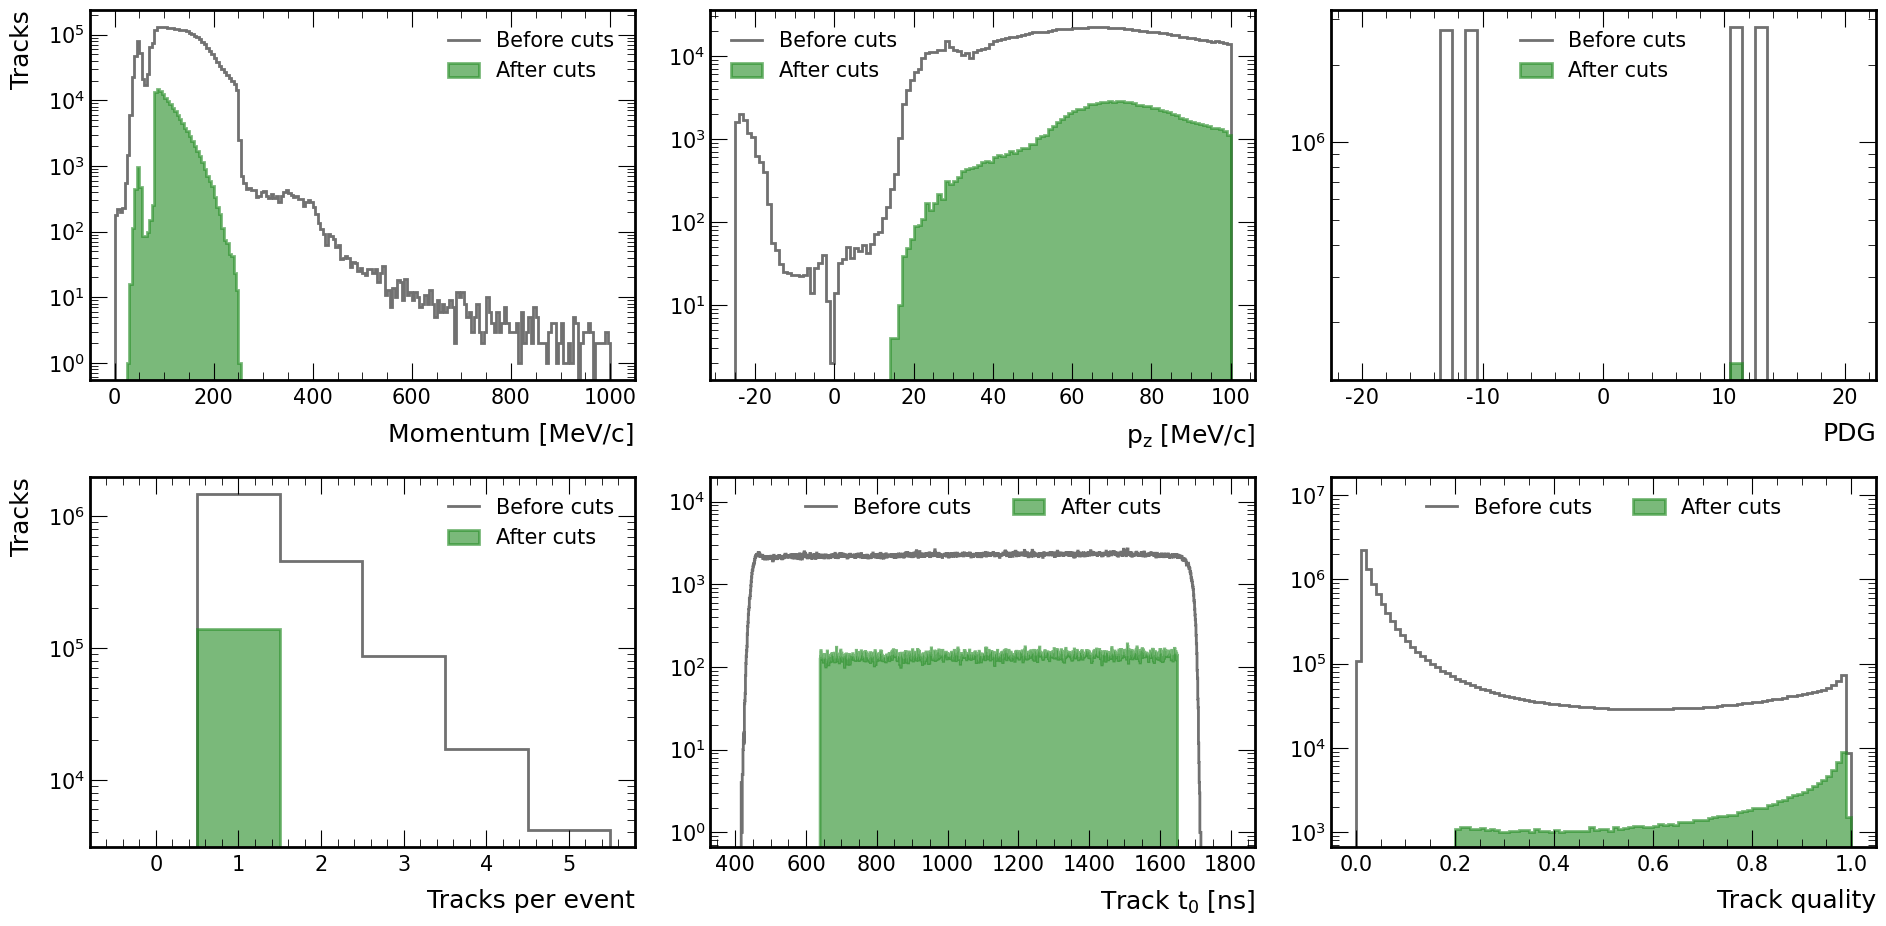

In [5]:
draw = Draw()

print("CRY")
draw.plot_ml_summary(cry_data["hists"])

print("CRY + PILEUP")
draw.plot_ml_summary(cry_mix_data["hists"])

In [6]:
print(cry_data["events"].type)
print(cry_mix_data["events"].type)

220408 * {event: float64, subrun: float64, crv_z: float32, crv_PEs: float32, dT: float64, t0: float64, d0: float32, tanDip: float32, maxr: float32}
393444 * {event: float64, subrun: float64, crv_z: float32, crv_PEs: float32, dT: float64, t0: float64, d0: float32, tanDip: float32, maxr: float32}


In [7]:
from pyutils.pyprint import Print
Print().print_n_events(cry_data["events"], 10)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 10 event(s)...

-------------------------------------------------------------------------------------
event: 133727.0
subrun: 17.0
crv_z: -4365.68505859375
crv_PEs: 725.133056640625
dT: 46.48246406151429
t0: 1283.0304376943268
d0: 130.94180297851562
tanDip: 1.2311159372329712
maxr: 512.3399658203125
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 178667.0
subrun: 17.0
crv_z: -4323.62255859375
crv_PEs: 562.4366455078125
dT: 28.693152145260797
t0: 870.7651736296358
d0: 206.88864135742188
tanDip: 0.7431459426879883
maxr: 672.4760131835938
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 461853.0
subrun: 17.0
crv_z: -6804.00390625
crv_PEs: 7

In [8]:
cry_data["events"]["crv_z"].type.show() # , axis=None)

220408 * float32


## Feature plots

In [11]:
help(plotter.plot_1D_overlay)

Help on method plot_1D_overlay in module pyutils.pyplot:

plot_1D_overlay(hists_dict, weights=None, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, out_path=None, dpi=300, leg=True, leg_pos='best', log_x=False, log_y=False, norm_by_area=False, styles=None, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Overlay multiple 1D histograms from a dictionary of arrays.

    Args:
        hists_dict (Dict[str, np.ndarray]): Dictionary mapping labels to arrays
        weights (List[np.ndarray], opt): List of weight arrays for each histogram. Defaults to None
        nbins (int, opt): Number of bins. Defaults to 100
        xmin (float, opt): Minimum x-axis value. Defaults to -1.0
        xmax (float, opt): Maximum x-axis value. Defaults to 1.0
        title (str, opt): Plot title. Defaults to None
        xlabel (str, opt): X-axis label. Defaults to None
        ylabel (str, opt): Y-axis label. Defaults to None
        out_path (str, opt): Path to save the p

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../../output/images/ml/veto/a/features/h1o_2x2_features.png


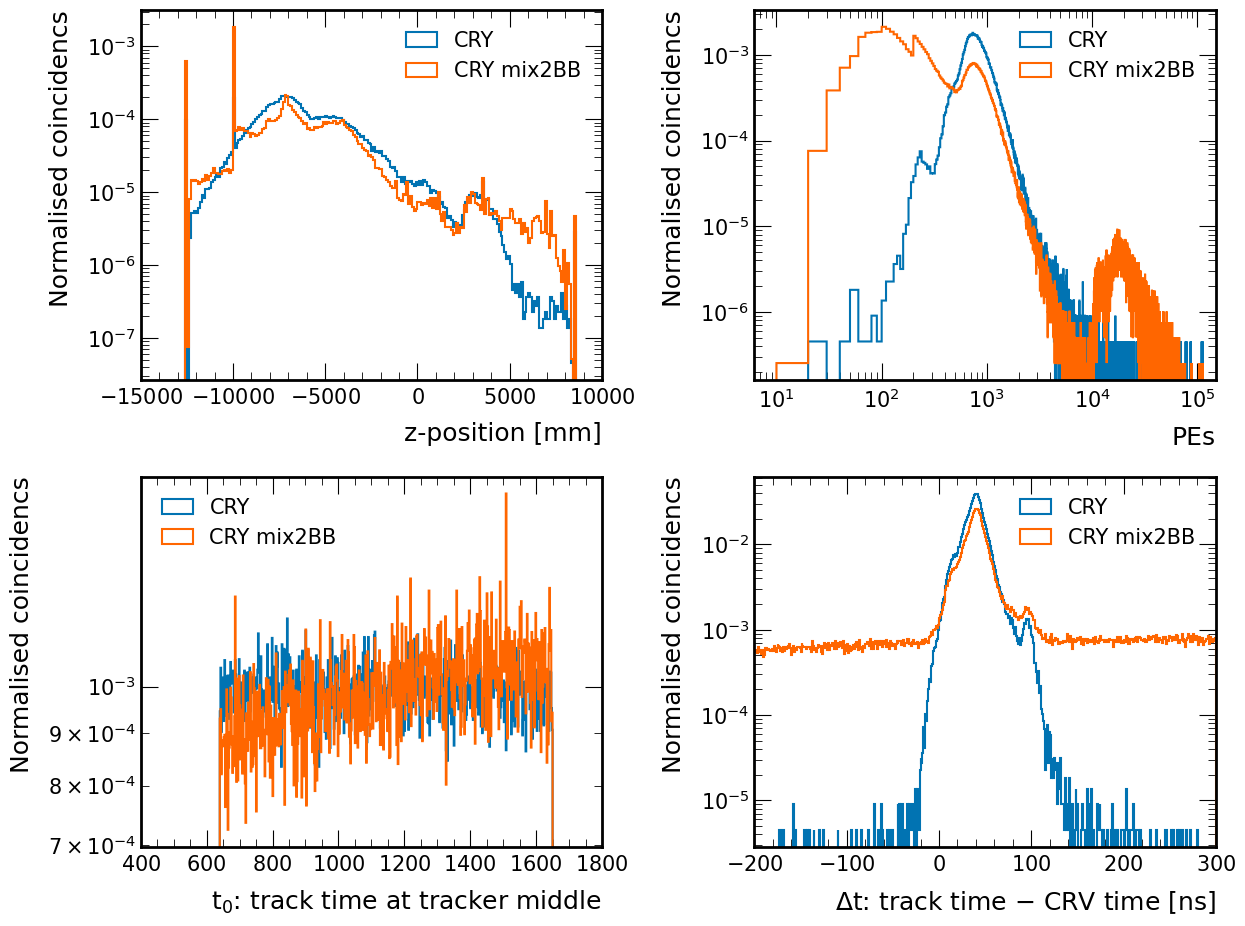

In [23]:
from pyutils.pyplot import Plot 
plotter = Plot()

fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))

styles = {

    "CRY" : { 
        "color" : "#0173B2"
    },
    "CRY mix2BB" : {
        "color" : "#FF6600"
    }
}
    

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_z"], axis=-1),
        "CRY mix2BB": ak.flatten(cry_mix_data["events"]["crv_z"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=250,
    xmin=-15000,
    xmax=10000,
    show=False,
    ax=ax[0,0],
    log_y=True,
    xlabel="z-position [mm]", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_PEs"], axis=-1),
        "CRY mix2BB": ak.flatten(cry_mix_data["events"]["crv_PEs"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=int(1.5e4),
    xmin=0,
    xmax=1.5e5,
    show=False,
    ax=ax[0,1],
    log_y=True,
    log_x=True,
    xlabel="PEs", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["t0"], axis=-1),
        "CRY mix2BB": ak.flatten(cry_mix_data["events"]["t0"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=700,
    xmin=400,
    xmax=1800,
    show=False,
    ax=ax[1,0],
    log_y=True,
    log_x=False,
    xlabel=r"$t_{0}$: track time at tracker middle", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)

plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["dT"], axis=-1),
        "CRY mix2BB": ak.flatten(cry_mix_data["events"]["dT"], axis=-1),
    },#  axis=None), # ["crvcoincs.pos.fCoordinates.fZ"]),
    nbins=int(500),
    xmin=-200,
    xmax=300,
    show=False,
    ax=ax[1,1],
    log_y=True,
    log_x=False,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]", 
    ylabel="Normalised coincidencs",
    norm_by_area=True,
    styles=styles
)


plt.tight_layout()

img_out_path = Path(f"../../../output/images/ml/veto/{run}/features")
img_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_out_path / "h1o_2x2_features.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
# plt.show()

	Wrote ../../../output/images/ml/veto/a/features/h2o_dT_vs_z.png


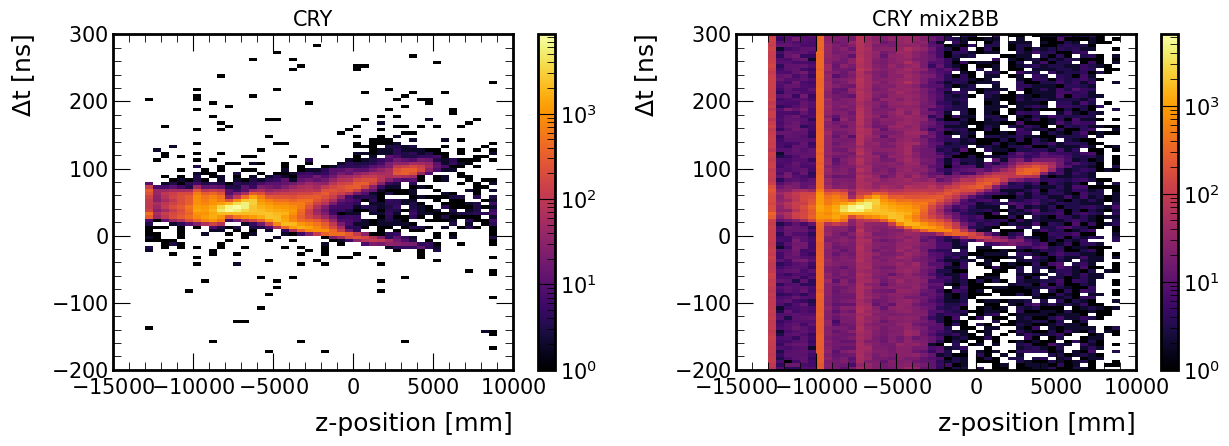

In [27]:
fig, ax = plt.subplots(1,2,figsize=(2*6.4, 4.8))
plotter.plot_2D(
    x = ak.flatten(cry_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(cry_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY",
    ax=ax[0]
)
plotter.plot_2D(
    x = ak.flatten(cry_mix_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(cry_mix_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY mix2BB",
    ax=ax[1]
)

out_name = img_out_path / "h2o_dT_vs_z.png"
plt.tight_layout()
plt.savefig(out_name)
print(f"\tWrote {out_name}")

## Training 

In [45]:
# Convert to DataFrame
feature_names = ["crv_z", "dT", "t0", "crv_PEs"]

df_CRY = ak.to_dataframe(cry_data["events"])
df_CRY_mix = ak.to_dataframe(cry_mix_data["events"])

# drop nactive and t0err
col_to_drop = ["event", "subrun", "d0", "tanDip", "maxr"] 

df_CRY.drop(columns=col_to_drop, axis=1, inplace=True)
df_CRY_mix.drop(columns=col_to_drop, axis=1, inplace=True)

df_CRY["label"] = 1 # "signal"
df_CRY_mix["label"] = 0 # "background"

In [29]:
# Combine and shuffle
df_train = pd.concat([df_CRY, df_CRY_mix], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_train)

,crv_z,crv_PEs,dT,t0,label
0,-5843.511230,705.081055,46.953947,1559.997159,0
1,-5526.345215,1052.679932,32.830333,1612.984874,1
2,-4101.127930,1027.052734,39.421188,1524.816940,0
3,1061.228760,1720.064575,83.024430,1022.673234,0
4,-9957.799805,506.588959,192.358336,930.413329,0
...,...,...,...,...,...
613847,-6295.091797,665.135559,46.941073,1240.933749,1
613848,-12567.763672,35290.484375,458.343487,1465.959942,0
613849,-9957.799805,699.062317,44.490054,711.781069,0
613850,-9934.852539,530.157104,39.687958,1456.894623,1


In [30]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")


Training: 491081 events
Test: 122771 events


In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [32]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Assign feature names for plotting / saving
model.get_booster().feature_names = feature_names

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!


## Store model

In [33]:
model_out_path = Path(f"../../../output/ml/veto/models/{run}")
model_out_path.mkdir(parents=True, exist_ok=True)

# Full path to model file
model_file_path = model_out_path / "trained_xgboost.json"

# Save the model
model.save_model(str(model_file_path))  # XGBoost often needs string path
print(f"\n✅ Done! Model saved to {model_file_path}")


✅ Done! Model saved to ../../../output/ml/veto/models/a/trained_xgboost.json


## Analyse model 

In [34]:
feature_names

['crv_z', 'dT', 't0', 'PEs']


⭐️ Feature importance:
  crv_z     : 0.0241
  dT        : 0.6449
  t0        : 0.3287
  PEs       : 0.0024


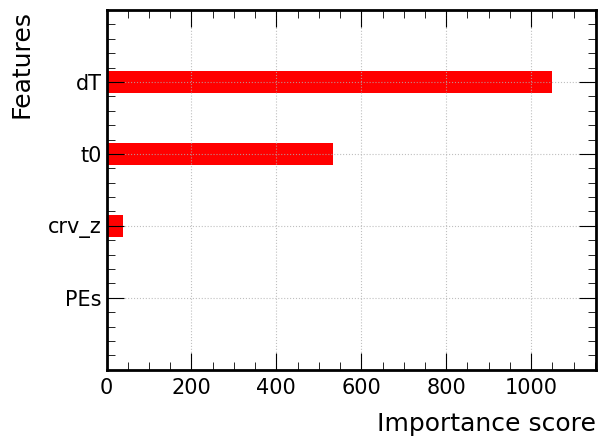

In [36]:
print("\n⭐️ Feature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}") 

xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.3)
plt.title("")
plt.tight_layout()

img_out_path = Path(f"../../../output/images/ml/veto/{run}/validation")
img_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_out_path / "bar_feature_importance.png" 
plt.savefig(out_name)
plt.show()

In [37]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training AUC: 0.8080
Test AUC: 0.8044


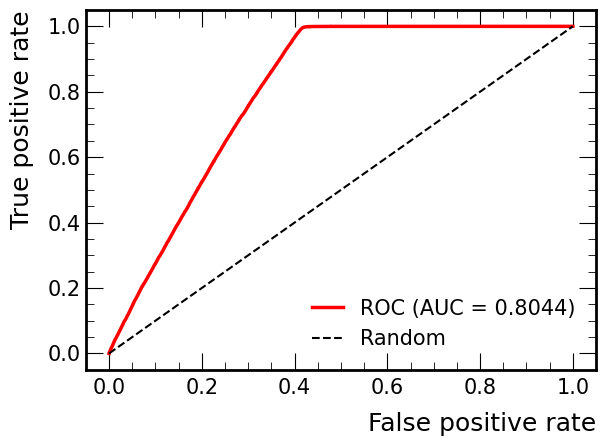


✅ Done! ROC curve saved to ../../../output/images/ml/veto/a/validation/roc_curve.png


In [39]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure()
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()

out_name = img_out_path / "roc_curve.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! ROC curve saved to {out_name}")

In [55]:
# print(model)                       # Full model structure summary
# print(model.get_params())           # Hyperparameters
# print(model.feature_importances_)   # Relative feature importance (you already printed these)

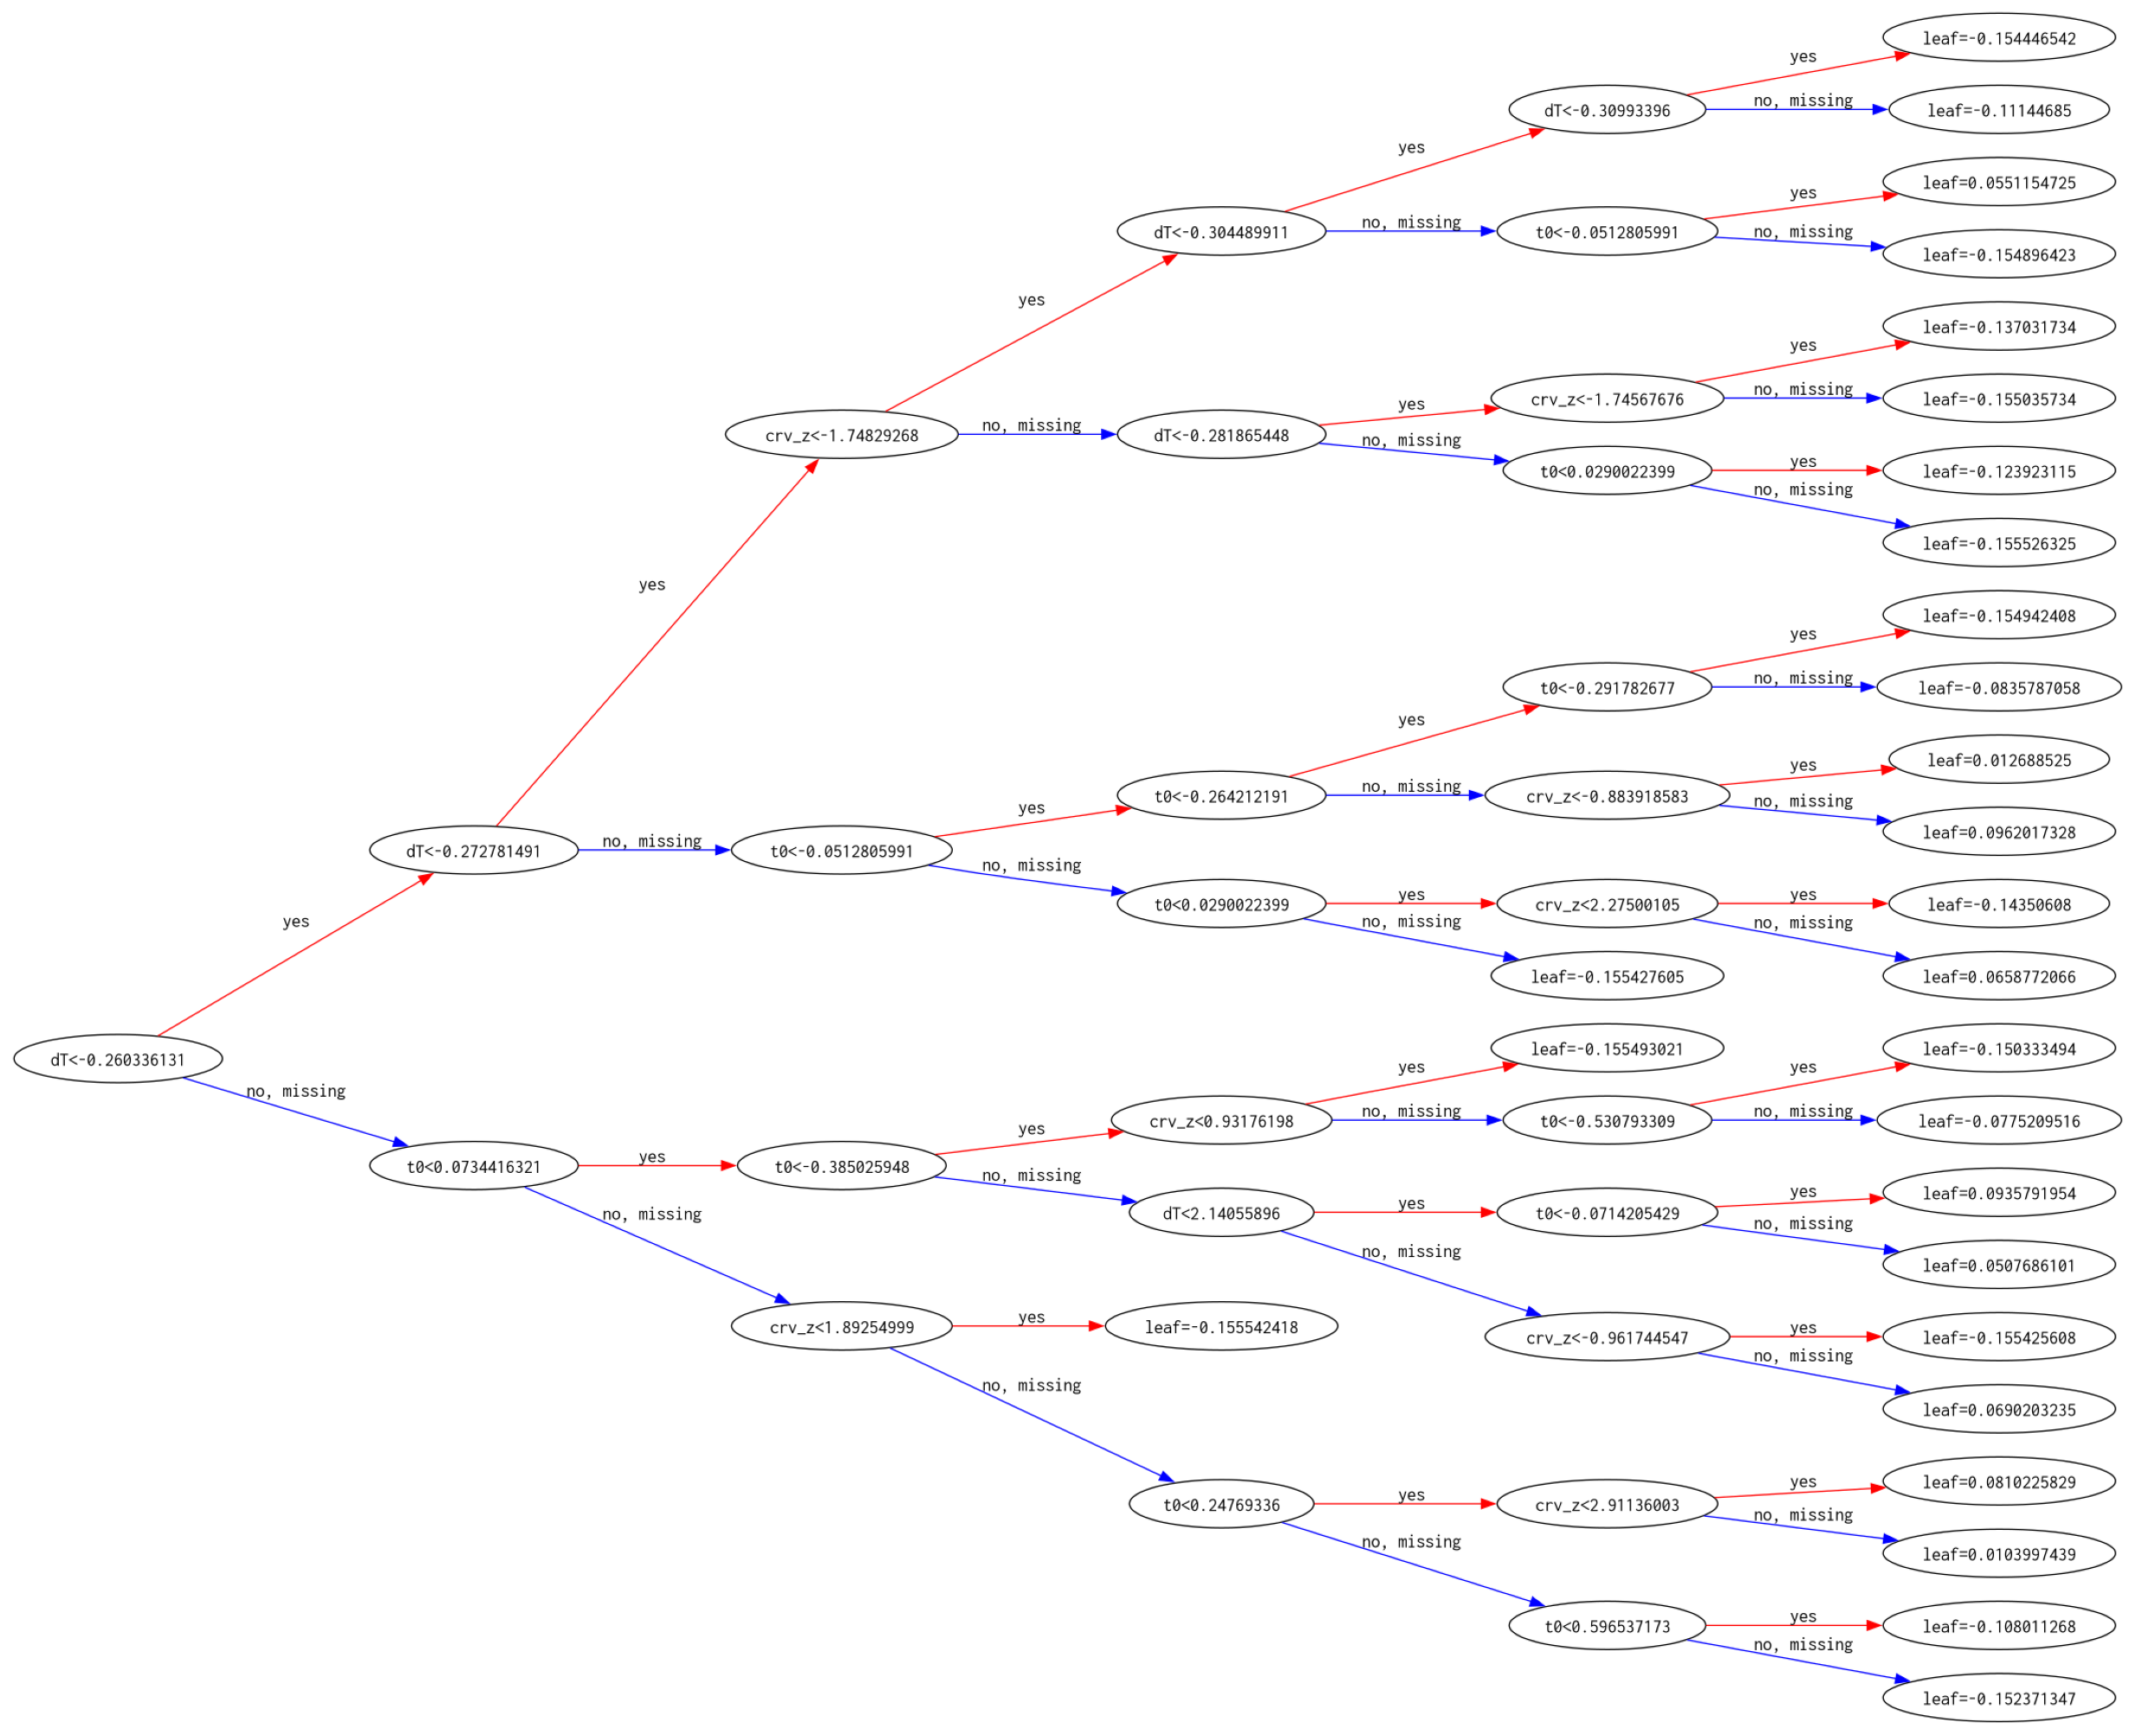


✅ Done! Tree saved to ../../../output/images/ml/veto/a/validation/tree_mix.png


In [40]:
fig, ax = plt.subplots(figsize=(25, 25))
xgb.plot_tree(model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()
out_path = img_out_path / "tree_mix.png"
plt.savefig(out_path)
plt.show()

print(f"\n✅ Done! Tree saved to {out_path}")

Optimal threshold: 0.263
Maximum significance: 158.5


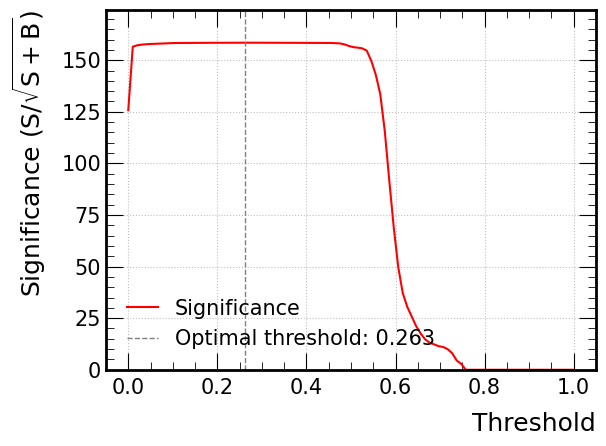


✅ Done! Signal signficance curve saved to ../../../output/images/ml/veto/a/validation/sig_sif.png


In [41]:
thresholds = np.linspace(0, 1, 100)
Z_values = []
for thr in thresholds:
    y_pred_label = (test_pred > thr).astype(int)
    S = ((y_test == 1) & (y_pred_label == 1)).sum()
    B = ((y_test == 0) & (y_pred_label == 1)).sum()
    if S+B > 0:
        Z_values.append(S / np.sqrt(S + B))
    else:
        Z_values.append(0)

optimal_idx = np.argmax(Z_values)
optimal_threshold = thresholds[optimal_idx]
max_significance = Z_values[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Maximum significance: {max_significance:.1f}")

plt.plot(thresholds, Z_values, label="Significance")
plt.ylim(0, max(Z_values) * 1.1)  # 10% headroom
plt.axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1, label=f'Optimal threshold: {optimal_threshold:.3f}')
plt.legend(loc="lower left")
plt.xlabel("Threshold")
plt.ylabel(r"Significance ($S/\sqrt{S+B}$)")
plt.grid()
plt.tight_layout()
out_path = img_out_path / "sig_sif.png"
plt.savefig(out_path)
plt.show()

print(f"\n✅ Done! Signal signficance curve saved to {out_path}")

In [31]:
# print(plt.style.library)

In [19]:
# # Choose your threshold based on desired signal efficiency
# threshold = 0.5  # Standard choice

# # Make binary decisions
# predictions = test_scores > threshold
# # predictions = [True, False, True, False, True, ...]

# # Or more explicitly:
# ce_selection = test_scores > threshold
# selected_events = X_test[ce_selection]

# print(f"Selected {ce_selection.sum()} events as CEs")

In [20]:
# import matplotlib.pyplot as plt

# # Separate scores by true label
# signal_scores = test_scores[y_test == 1]  # True signal
# cosmic_scores = test_scores[y_test == 0]  # True background

# plt.figure(figsize=(10, 6))
# plt.hist(cosmic_scores, bins=50, alpha=0.6, label='Cosmics', 
#          density=True, color='orange')
# plt.hist(ce_scores, bins=50, alpha=0.6, label='CEs', 
#          density=True, color='blue')

# plt.axvline(0.5, color='grey', linestyle='--', linewidth=1, 
#             label=f'Threshold = {optimal_threshold}')

# plt.xlabel('Model score')
# plt.ylabel('Density')
# plt.title('Score distribution')
# plt.legend()

# plt.show()

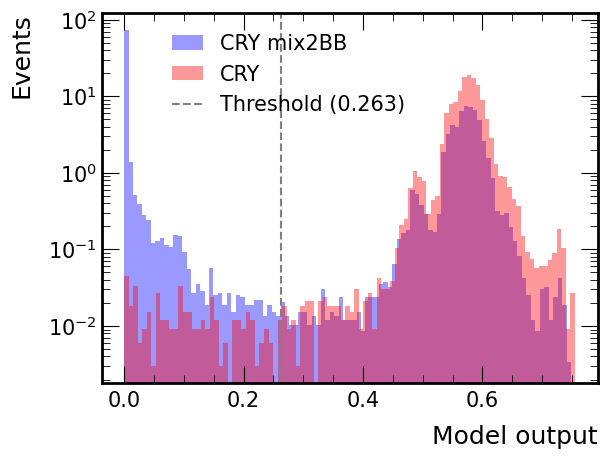

In [42]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
cosmic_scores = test_scores[y_test == 0]  # CRY + mix2BB

# Define threshold
threshold = 0.5

# Compute FPR and FNR
false_positives = (cosmic_scores > threshold).sum()   # Background misclassified as signal
true_negatives  = (cosmic_scores <= threshold).sum()

false_negatives = (signal_scores <= threshold).sum()  # Signal misclassified as background
true_positives  = (signal_scores > threshold).sum()

fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)

# Plot score distributions
plt.figure() 

plt.hist(cosmic_scores, bins=100, alpha=0.4, label='CRY mix2BB',
         density=True, color='blue')
plt.hist(signal_scores, bins=100, alpha=0.4, label='CRY',
         density=True, color='red')

plt.axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


plt.xlabel('Model output')
plt.ylabel('Events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
out_name = img_out_path / "model_output.png"
plt.savefig(out_name)
print
plt.show()


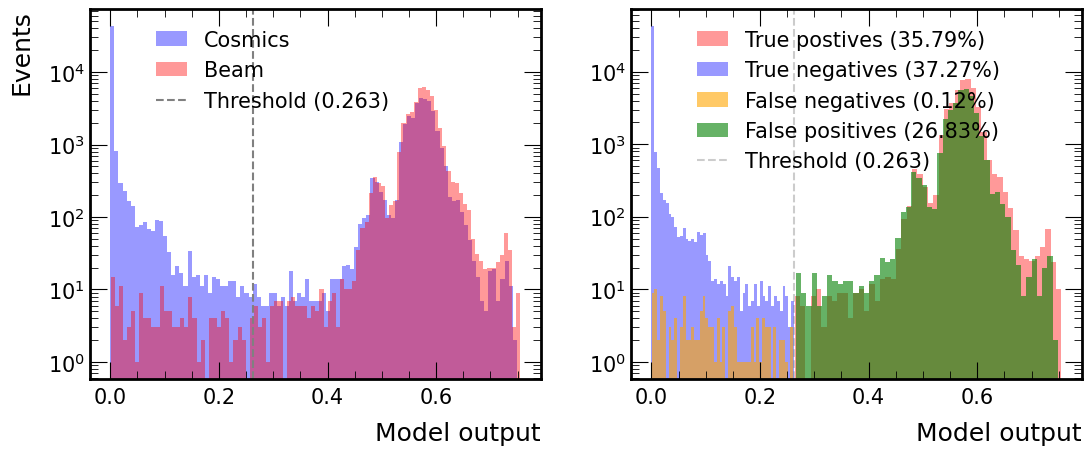

In [43]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # True signal 
cosmic_scores = test_scores[y_test == 0]  # True background 

# Discrimination threshold
threshold = optimal_threshold

# Get false positives and false negatives
false_positives = cosmic_scores[cosmic_scores > threshold]
false_negatives = signal_scores[signal_scores <= threshold]

# Also get true positives and true negatives for comparison
true_positives = signal_scores[signal_scores > threshold]
true_negatives = cosmic_scores[cosmic_scores <= threshold]

# # Boolean masks
# tp_mask = (y_test == 1) & (y_pred_label == 1)
# tn_mask = (y_test == 0) & (y_pred_label == 0)
# fp_mask = (y_test == 0) & (y_pred_label == 1)
# fn_mask = (y_test == 1) & (y_pred_label == 0)


tot = len(test_scores)

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

ax[0].hist(cosmic_scores, bins=100, alpha=0.4, label='Cosmics',
         density=False, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.4, label='Beam',
         density=False, color='red')
ax[0].axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')


ax[1].hist(true_positives, bins=50, alpha=0.4, label=f'True postives ({len(true_positives)*100/tot:.2f}%)', color='red')
ax[1].hist(true_negatives, bins=50, alpha=0.4, label=f'True negatives ({len(true_negatives)*100/tot:.2f}%)', color='blue')
ax[1].hist(false_negatives, bins=50, alpha=0.6, label=f'False negatives ({len(false_negatives)*100/tot:.2f}%)', color='orange')
ax[1].hist(false_positives, bins=50, alpha=0.6, label=f'False positives ({len(false_positives)*100/tot:.2f}%)', color='green')
ax[1].axvline(optimal_threshold, color='grey', linestyle='--', linewidth=1.5, alpha=0.4, label=f"Threshold ({optimal_threshold:.3f})")


ax[1].set_xlabel('Model output')
ax[1].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[1].set_yscale('log')


out_name = img_out_path / "h1o_1x2_model_output.png"
plt.savefig(out_name)


plt.show()


In [82]:
X_test_scaled

array([[-0.55645783, -0.27832736, -0.61962159, -0.85490828, -0.02135168],
       [-0.76640152, -0.19750665,  0.12687301, -0.41930555, -1.35682202],
       [-1.46621382, -0.12697703,  0.59624474,  0.27487708, -0.81531951],
       ...,
       [ 0.28331693, -0.28067537, -0.0019874 ,  0.06577673,  0.26380258],
       [ 0.84316677, -0.44689293, -0.49011902, -0.66889314,  0.4415214 ],
       [-0.4864766 , -0.26362161, -0.44578287, -0.33408852,  0.22801053]])

	Wrote ../../../output/images/ml/veto/a/validation/features_output.png


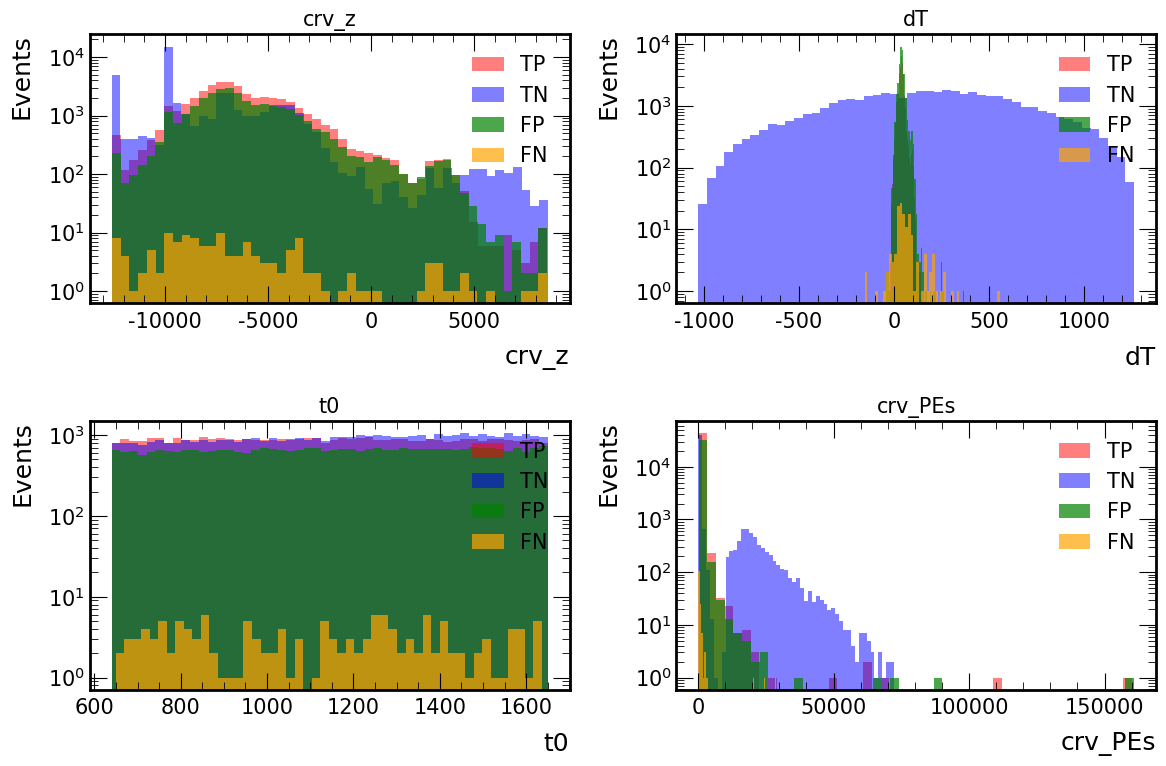

In [55]:
# Create a grid of subplots
n_features = len(feature_names)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

y_pred_label = (test_scores > threshold).astype(int)
# Boolean masks
tp_mask = (y_test == 1) & (y_pred_label == 1)
tn_mask = (y_test == 0) & (y_pred_label == 0)
fp_mask = (y_test == 0) & (y_pred_label == 1)
fn_mask = (y_test == 1) & (y_pred_label == 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    ax.hist(X_test[feature][tp_mask], bins=50, color='red', alpha=0.5, label='TP')
    ax.hist(X_test[feature][tn_mask], bins=50, color='blue', alpha=0.5, label='TN')
    ax.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.7, label='FP')
    ax.hist(X_test[feature][fn_mask], bins=50, color='orange', alpha=0.7, label='FN')
    xlabel = feature
    # if feature in ["d0", "maxr"]: 
    #     xlabel += " [mm]"
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Events')
    ax.set_yscale('log')
    ax.legend() # fontsize=8)


        
    ax.set_title(feature)

# Hide unused subplots
for idx in range(len(feature_names), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

out_name = img_out_path / "features_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")

plt.show()

In [87]:
# true_positives.keys()

In [47]:
# Signal efficiency (True Positive Rate / Recall)
signal_efficiency = len(true_positives) / len(signal_scores)

# Background rejection rate (True Negative Rate / Specificity)
background_rejection = len(true_negatives) / len(cosmic_scores)

# Background efficiency (what you're rejecting FROM)
background_efficiency = len(false_positives) / len(cosmic_scores)

print(f"Signal Efficiency: {signal_efficiency*100:.2f}%")
print(f"Background Rejection: {background_rejection*100:.2f}%")
print(f"Background Contamination: {background_efficiency*100:.2f}%")

# Check class balance
print(f"\nClass balance:")
print(f"Signal events: {len(signal_scores)} ({len(signal_scores)*100/tot:.2f}%)")
print(f"Background events: {len(cosmic_scores)} ({len(cosmic_scores)*100/tot:.2f}%)")

Signal Efficiency: 99.67%
Background Rejection: 58.15%
Background Contamination: 41.85%

Class balance:
Signal events: 44082 (35.91%)
Background events: 78689 (64.09%)


In [ ]:
## Kinematic cuts

In [48]:
# # Example traditional cuts (adjust these to your physics case)
# def apply_kin_cuts(X):
#     """Apply kinematic parameter cuts for signal selection"""
#     cuts = (
#         (X['d0'] < 100) &           
#         (X['maxr'] < 680) &         
#         (X['tanDip'] > 0.5) &  
#         (X['tanDip'] < 1.0) # &        
#         # (X['t0err'] < 0.9)   
#     )
#     return cuts

# # Apply cuts to test set

# cut_based_pred = apply_kin_cuts(X_test).astype(int)

# print(X_test)
# print(len(cut_based_pred[cut_based_pred==1])/len(cut_based_pred))
# # print(len(X_test), len(cut_based_pred[2]))
# # cut_based_pred = apply_kin_cuts(X_test).astype(int)

In [49]:
# from sklearn.metrics import confusion_matrix, classification_report

# # ML predictions
# y_pred_ml = (test_scores > optimal_threshold).astype(int)

# # Calculate confusion matrices
# cm_ml = confusion_matrix(y_test, y_pred_ml)
# cm_cuts = confusion_matrix(y_test, cut_based_pred)

# # Extract TP, TN, FP, FN for both methods
# def get_metrics(cm):
#     tn, fp, fn, tp = cm.ravel()
    
#     signal_efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
#     background_rejection = tn / (tn + fp) if (tn + fp) > 0 else 0
#     purity = tp / (tp + fp) if (tp + fp) > 0 else 0
    
#     # Calculate significance
#     S = tp
#     B = fp
#     significance = S / np.sqrt(S + B) if (S + B) > 0 else 0
    
#     return {
#         'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
#         'Signal efficiency': signal_efficiency,
#         'Background rejection': background_rejection,
#         'Purity': purity,
#         'Significance': significance
#     }

# metrics_ml = get_metrics(cm_ml)
# metrics_cuts = get_metrics(cm_cuts)

# # # Print comparison
# # print("=" * 60)
# # print("Performance comparison: ML vs kinematic cuts")
# # print("=" * 60)
# # print(f"{'Metric':<25} {'ML':<15} {'Cuts':<15} {'Improvement':<15}")
# # print("-" * 60)

# # for key in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']:
# #     ml_val = metrics_ml[key]
# #     cut_val = metrics_cuts[key]
# #     improvement = ((ml_val - cut_val) / cut_val * 100) if cut_val > 0 else 0
    
# #     print(f"{key:<25} {ml_val:.4f}        {cut_val:.4f}        {improvement:+.1f}%")

# # print("-" * 60)
# # print(f"{'True positives':<25} {metrics_ml['TP']:<15} {metrics_cuts['TP']:<15}")
# # print(f"{'False positives':<25} {metrics_ml['FP']:<15} {metrics_cuts['FP']:<15}")
# # print(f"{'False negatives':<25} {metrics_ml['FN']:<15} {metrics_cuts['FN']:<15}")
# # print(f"{'True negatives':<25} {metrics_ml['TN']:<15} {metrics_cuts['TN']:<15}")


# # Metrics DataFrame (with percentages/rates)
# metrics_df = pd.DataFrame({
#     'Metric': ['Signal efficiency', 'Background rejection', 'Purity', 'Significance'],
#     'ML': [metrics_ml[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']],
#     'Cuts': [metrics_cuts[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']]
# })
# metrics_df['Improvement [%]'] = ((metrics_df['ML'] - metrics_df['Cuts']) / metrics_df['Cuts'] * 100)

# # Counts DataFrame
# # counts_df = pd.DataFrame({
# #     'Category': ['True positives', 'False positives', 'False negatives', 'True negatives'],
# #     'ML': [metrics_ml['TP'], metrics_ml['FP'], metrics_ml['FN'], metrics_ml['TN']],
# #     'Cuts': [metrics_cuts['TP'], metrics_cuts['FP'], metrics_cuts['FN'], metrics_cuts['TN']]
# # })

# counts_df = pd.DataFrame({
#     'Category': ['True positives', 'True negatives', 'False positives', 'False negatives'],
#     'ML': [metrics_ml['TP'], metrics_ml['TN'], metrics_ml['FP'], metrics_ml['FN']],
#     'Cuts': [metrics_cuts['TP'], metrics_cuts['TN'], metrics_cuts['FP'], metrics_cuts['FN']]
# })

# counts_df['Difference'] = counts_df['ML'] - counts_df['Cuts']

# print("\n=== Performance metrics ===")
# display(metrics_df)
# print("\n=== Event counts ===")
# display(counts_df)



In [50]:
# # Cosmic Ray Rejection Performance Table
# cosmic_rejection_df = pd.DataFrame({
#     'Metric': [
#         'Cosmic rays rejected (TN)',
#         'Cosmic rays accepted (FP)', 
#         'Background rejection rate',
#         'Cosmic contamination rate',
#         'Sample purity (beam)',
#         'Beam events retained (TP)',
#         'Beam signal efficiency',
#         'Overall significance (S/√(S+B))'
#     ],
#     'ML': [
#         metrics_ml['TN'],
#         metrics_ml['FP'],
#         f"{metrics_ml['Background rejection']*100:.2f}%",
#         f"{(metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']))*100:.2f}%",
#         f"{metrics_ml['Purity']*100:.2f}%",
#         metrics_ml['TP'],
#         f"{metrics_ml['Signal efficiency']*100:.2f}%",
#         f"{metrics_ml['Significance']:.1f}"
#     ],
#     'Cuts': [
#         metrics_cuts['TN'],
#         metrics_cuts['FP'],
#         f"{metrics_cuts['Background rejection']*100:.2f}%",
#         f"{(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100:.2f}%",
#         f"{metrics_cuts['Purity']*100:.2f}%",
#         metrics_cuts['TP'],
#         f"{metrics_cuts['Signal efficiency']*100:.2f}%",
#         f"{metrics_cuts['Significance']:.1f}"
#     ],
#     'Improvement': [
#         f"+{metrics_ml['TN'] - metrics_cuts['TN']}",
#         f"{metrics_ml['FP'] - metrics_cuts['FP']}",
#         f"+{((metrics_ml['Background rejection'] - metrics_cuts['Background rejection'])/metrics_cuts['Background rejection']*100):.1f}%",
#         f"{((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%",
#         f"+{(metrics_ml['Purity'] - metrics_cuts['Purity'])*100:.2f}%",
#         f"+{metrics_ml['TP'] - metrics_cuts['TP']}",
#         f"+{((metrics_ml['Signal efficiency'] - metrics_cuts['Signal efficiency'])/metrics_cuts['Signal efficiency']*100):.1f}%",
#         f"+{((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}%"
#     ]
# })

# print("\n" + "="*80)
# print("COSMIC RAY REJECTION PERFORMANCE: ML vs Kinematic Cuts")
# print("="*80)
# display(cosmic_rejection_df)

# # Add summary statistics
# total_cosmics = metrics_ml['TN'] + metrics_ml['FP']
# total_beam = metrics_ml['TP'] + metrics_ml['FN']

# print("\n" + "="*80)
# print("KEY FINDINGS")
# print("="*80)
# print(f"• ML rejects {metrics_ml['TN'] - metrics_cuts['TN']} additional cosmic ray backgrounds")
# print(f"• ML reduces cosmic contamination by {abs((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%")
# print(f"• ML retains {metrics_ml['TP'] - metrics_cuts['TP']} additional beam events")
# print(f"• Net result: {((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}% improvement in significance")
# print(f"\nDataset composition: {total_beam:,} beam events, {total_cosmics:,} cosmic events")

In [51]:
# # # Selection rate on PURE signal dataset
# # signal_selection_rate = metrics_cuts['TP'] / (metrics_cuts['TP'] + metrics_cuts['FN'])
# # print(f"Signal selection rate (cuts): {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")

# # # This is actually the same as signal efficiency!
# # # It's asking: "Of all signal events, what fraction passes cuts?"

# # # For comparison - ML signal selection rate
# # signal_selection_rate_ml = metrics_ml['TP'] / (metrics_ml['TP'] + metrics_ml['FN'])
# # print(f"Signal selection rate (ML): {signal_selection_rate_ml:.4f} ({signal_selection_rate_ml*100:.2f}%)")

# # # Background selection rate (what fraction of background passes - you want this LOW)
# # background_selection_rate_cuts = metrics_cuts['FP'] / (metrics_cuts['FP'] + metrics_cuts['TN'])
# # background_selection_rate_ml = metrics_ml['FP'] / (metrics_ml['FP'] + metrics_ml['TN'])

# # print(f"\nBackground selection rate (cuts): {background_selection_rate_cuts:.4f} ({background_selection_rate_cuts*100:.2f}%)")
# # print(f"Background selection rate (ML): {background_selection_rate_ml:.4f} ({background_selection_rate_ml*100:.2f}%)")

# # Apply cuts to the pure signal dataset
# cut_based_sig = apply_kin_cuts(df_sig.drop('label', axis=1))

# # Calculate selection rate on pure signal sample
# signal_selection_rate = cut_based_sig.sum() / len(df_sig)
# print(f"Selection rate on pure signal dataset: {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")
# print(f"Events passing cuts: {cut_based_sig.sum()} / {len(df_sig)}")

# # Compare to what you got on test set
# print(f"\nFor comparison:")
# print(f"Signal efficiency on test set: {metrics_cuts['Signal efficiency']:.4f} ({metrics_cuts['Signal efficiency']*100:.2f}%)")

# # Apply cuts to pure background dataset
# cut_based_bkg = apply_kin_cuts(df_bkg.drop('label', axis=1))

# background_selection_rate = cut_based_bkg.sum() / len(df_bkg)
# print(f"Selection rate on pure background dataset: {background_selection_rate:.4f} ({background_selection_rate*100:.2f}%)")
# print(f"\nFor comparison:")
# print(f"Background contamination on test set: {1 - metrics_cuts['Background rejection']:.4f} ({(1 - metrics_cuts['Background rejection'])*100:.2f}%)")

In [52]:
# from sklearn.metrics import roc_curve, auc

# # ML ROC curve
# fpr_ml, tpr_ml, _ = roc_curve(y_test, test_scores)
# roc_auc_ml = auc(fpr_ml, tpr_ml)

# # For cut-based, create a simple ROC point
# tpr_cuts = metrics_cuts['Signal efficiency']
# fpr_cuts = 1 - metrics_cuts['Background rejection']

# plt.figure(figsize=(8, 6))
# plt.plot(fpr_ml, tpr_ml, label=f'ML (AUC = {roc_auc_ml:.3f})', linewidth=2)
# plt.scatter(fpr_cuts, tpr_cuts, color='blue', s=100, zorder=5, 
#            label=f'Kinematic cuts', marker='o')
# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel(r'False positive rate (1 $-$ background rejection)')
# plt.ylabel('True positive rate (signal efficiency)')
# plt.title('ROC curve: ML vs cuts')
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.tight_layout()

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
# out_name = f"{out_path}/roc_curve_kin_cuts.png"
# plt.savefig(out_name)


# plt.show()

In [53]:
# # Scan thresholds for both methods
# thresholds_ml = np.linspace(0, 1, 100)
# significance_ml = []

# for thr in thresholds_ml:
#     y_pred = (test_scores > thr).astype(int)
#     S = ((y_test == 1) & (y_pred == 1)).sum()
#     B = ((y_test == 0) & (y_pred == 1)).sum()
#     sig = S / np.sqrt(S + B) if (S + B) > 0 else 0
#     significance_ml.append(sig)

# # Get cut-based significance (single point)
# S_cuts = metrics_cuts['TP']
# B_cuts = metrics_cuts['FP']
# sig_cuts = metrics_cuts['Significance']

# plt.figure() # figsize=(10, 6))
# plt.plot(thresholds_ml, significance_ml, label='ML', linewidth=2)
# plt.axhline(sig_cuts, color='grey', linestyle='--', linewidth=2, 
#            label=f'Cuts (Sig = {sig_cuts:.2f})')
# plt.axvline(optimal_threshold, color='grey', linewidth=2, linestyle=':',
#            label=f'Optimal threshold ({optimal_threshold:.3f})')
# plt.xlabel('Threshold')
# plt.ylabel(r'Significance ($S/\sqrt{S+B}$)')
# plt.title('Signal significance: ML vs cuts')
# plt.legend(loc="lower left")
# plt.grid(alpha=0.3)
# plt.tight_layout()

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
# out_name = f"{out_path}/sig_sif_mix_kin_cuts.png"
# plt.savefig(out_name)

# plt.show()

# print(f"\nMaximum ML Significance: {max(significance_ml):.2f}")
# print(f"Cut-based Significance: {sig_cuts:.2f}")
# print(f"Improvement: {(max(significance_ml) - sig_cuts)/sig_cuts*100:.1f}%")

In [54]:
# # Show which events pass ML but fail cuts, and vice versa
# ml_only = (y_pred_ml == 1) & (cut_based_pred == 0)
# cuts_only = (y_pred_ml == 0) & (cut_based_pred == 1)
# both = (y_pred_ml == 1) & (cut_based_pred == 1)

# print(f"\nEvents passing ML only: {ml_only.sum()}")
# print(f"Events passing Cuts only: {cuts_only.sum()}")
# print(f"Events passing both: {both.sum()}")

In [78]:
# feature = 'd0'

# plt.figure(figsize=(8,6))
# plt.hist(X_test[feature][tp_mask], bins=50, color='royalblue', alpha=0.5, label='True Positives')
# plt.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.5, label='False Positives')
# plt.hist(X_test[feature][fn_mask], bins=50, color='khaki', alpha=0.7, label='False Negatives')
# plt.hist(X_test[feature][tn_mask], bins=50, color='red', alpha=0.5, label='True Negatives')
# plt.xlabel(feature)
# plt.ylabel('# of events')
# plt.yscale('log')
# plt.legend()
# plt.title(f'{feature} distribution by classification result')
# plt.show()


In [79]:
# # import xgboost as xgb
# # import matplotlib.pyplot as plt

# # xgb.plot_tree(model, num_trees=0, rankdir="LR")  # "LR" = left-to-right
# # plt.show()

# from xgboost import to_graphviz

# # Generate a Graphviz object
# dot = to_graphviz(model, num_trees=0, rankdir="LR")

# # Save as a crisp vector PDF
# dot.render("xgb_tree", format="pdf")

# # or as a high-quality PNG (set dpi)
# dot.render("xgb_tree", format="png")



In [80]:
# xgb.plot_importance(model, importance_type='gain')
# plt.tight_layout()
# plt.show()